In [2]:
#initializing node structure
import chess
import chess.pgn
import chess.engine
import random
import time
import numpy as np
from matplotlib import pyplot as plt
from math import log,sqrt,e,inf
from IPython.display import display, HTML, clear_output
#engine = chess.engine.SimpleEngine.popen_uci(r'stockfish-11-win/Windows/stockfish_20011801_x64.exe')

engine = chess.engine.SimpleEngine.popen_uci("stockfish")


class node:
    def __init__(self,*board):
        if(len(board)>0):
            self.state = board
        else:
            self.state = chess.Board()
        self.action = ''
        self.children = set()
        self.parent = None
        self.N = 0
        self.n = 0
        self.v = 0

In [ ]:
#method for ucb and AI rollout
def ucb1(curr_node):
    ans = curr_node.v+2*(sqrt(log(curr_node.N+e+(10**-6))/(curr_node.n+(10**-10))))
    return ans

def rollout(board,curr_node):
    global engine
    if(curr_node.state.is_game_over()):
        board1 = curr_node.state
        if(board1.result()=='1-0'):
            return (1,curr_node)
        elif(board1.result()=='0-1'):
            return (-1,curr_node)
        else:
            return (0.5,curr_node)
    
    all_moves = [curr_node.state.san(i) for i in list(curr_node.state.legal_moves)]
    result = engine.play(curr_node.state, chess.engine.Limit(time=0.001))
    move = curr_node.state.san(result.move)
    tmp_state = chess.Board(curr_node.state.fen())
    tmp_state.push_san(move)

    to_use = None
    
    for i in all_moves:
        tmp_state1 = chess.Board(curr_node.state.fen())
        tmp_state1.push_san(i)
        child = node()
        child.state = tmp_state1
        child.parent = curr_node
        curr_node.children.add(child)
        if(child.state==tmp_state):
            to_use = child
            break
            
    return rollout(board,to_use)





In [ ]:
#method for baseline tree rollout
def rolloutTree(board,curr_node):
    
    if(curr_node.state.is_game_over()):
        board1 = curr_node.state
        if(board1.result()=='1-0'):
            return (1,curr_node)
        elif(board1.result()=='0-1'):
            return (-1,curr_node)
        else:
            return (0.5,curr_node)
    
    all_moves = [curr_node.state.san(i) for i in list(curr_node.state.legal_moves)]
    
    for i in all_moves:
        tmp_state = chess.Board(curr_node.state.fen())
        tmp_state.push_san(i)
        child = node(board)
        child.state = tmp_state
        child.parent = curr_node
        curr_node.children.add(child)
    rnd_state = random.choice(list(curr_node.children))

    return rolloutTree(board,rnd_state)


In [ ]:
def expand(curr_node,white):
    if(len(curr_node.children)==0):
        return curr_node
    max_ucb = -inf
    if(white):
        idx = -1
        max_ucb = -inf
        sel_child = None
        for i in curr_node.children:
            tmp = ucb1(i)
            if(tmp>max_ucb):
                idx = i
                max_ucb = tmp
                sel_child = i

        return(expand(sel_child,0))

    else:
        idx = -1
        min_ucb = inf
        sel_child = None
        for i in curr_node.children:
            tmp = ucb1(i)
            if(tmp<min_ucb):
                idx = i
                min_ucb = tmp
                sel_child = i

        return expand(sel_child,1)


In [ ]:
def rollback(curr_node,reward):
    curr_node.n+=1
    curr_node.v+=reward
    while(curr_node.parent!=None):
        curr_node.N+=1
        curr_node = curr_node.parent
    return curr_node


In [ ]:
def mcts_pred(board,curr_node,over,white,choice,base1,base2,iterations=10):
    if(over):
        return -1
    all_moves = [curr_node.state.san(i) for i in list(curr_node.state.legal_moves)]
    map_state_move = dict()
    
    for i in all_moves:
        tmp_state = chess.Board(curr_node.state.fen())
        tmp_state.push_san(i)
        child = node(board)
        child.state = tmp_state
        child.parent = curr_node
        curr_node.children.add(child)
        map_state_move[child] = i
        
    while(iterations>0):
        if(white):
            idx = -1
            max_ucb = -inf
            sel_child = None
            for i in curr_node.children:
                tmp = ucb1(i)
                if(tmp>max_ucb):
                    idx = i
                    max_ucb = tmp
                    sel_child = i
            ex_child = expand(sel_child,0)
            if(base1=="Tree"):
                reward,state = rolloutTree(board,ex_child)
            elif(base1=="AI"):
                reward,state = rollout(board,ex_child)
            curr_node = rollback(state,reward)
            iterations-=1
        else:
            idx = -1
            min_ucb = inf
            sel_child = None
            for i in curr_node.children:
                tmp = ucb1(i)
                if(tmp<min_ucb):
                    idx = i
                    min_ucb = tmp
                    sel_child = i

            ex_child = expand(sel_child,1)

            if(base2=="Tree"):
                reward,state = rolloutTree(board,ex_child)
            elif(base2=="AI"):
                reward,state = rollout(board,ex_child)

            curr_node = rollback(state,reward)
            iterations-=1

    if(white):
        
        mx = -inf
        idx = -1
        selected_move = ''
        for i in (curr_node.children):
            tmp = ucb1(i)
            if(tmp>mx):
                mx = tmp
                selected_move = map_state_move[i]
        return selected_move
    else:
        mn = inf
        idx = -1
        selected_move = ''
        for i in (curr_node.children):
            tmp = ucb1(i)
            if(tmp<mn):
                mn = tmp
                selected_move = map_state_move[i]
        return selected_move
    



In [ ]:
def staticAnalysis(board, color):
    score = random.random()

    ## Check some things about this move:
    # score += 10 if board.is_capture(move) else 0
    # Now check some other things:
    for (piece, value) in [(chess.PAWN, 1), 
                           (chess.BISHOP, 4), 
                           (chess.KING, 0), 
                           (chess.QUEEN, 10), 
                           (chess.KNIGHT, 5),
                           (chess.ROOK, 3)]:
        score += len(board.pieces(piece, color)) * value
        score -= len(board.pieces(piece, not color)) * value
        # can also check things about the pieces position here
    # Check global things about the board
    score += 100 if board.is_checkmate() else 0
    return score



In [ ]:
import os
import chess
import numpy as np
os.getcwd()
os.chdir(os.path.dirname(os.path.abspath("__file__")))
#os.chdir('C:\Users\User\Downloads\stockfish-11-win')
import chess.pgn
import pandas as pd
#https://www.kaggle.com/code/gabrielhaselhurst/chess-dataset/data
chess_dict = {
    'p' : [1,0,0,0,0,0,0,0,0,0,0,0],
    'P' : [0,0,0,0,0,0,1,0,0,0,0,0],
    'n' : [0,1,0,0,0,0,0,0,0,0,0,0],
    'N' : [0,0,0,0,0,0,0,1,0,0,0,0],
    'b' : [0,0,1,0,0,0,0,0,0,0,0,0],
    'B' : [0,0,0,0,0,0,0,0,1,0,0,0],
    'r' : [0,0,0,1,0,0,0,0,0,0,0,0],
    'R' : [0,0,0,0,0,0,0,0,0,1,0,0],
    'q' : [0,0,0,0,1,0,0,0,0,0,0,0],
    'Q' : [0,0,0,0,0,0,0,0,0,0,1,0],
    'k' : [0,0,0,0,0,1,0,0,0,0,0,0],
    'K' : [0,0,0,0,0,0,0,0,0,0,0,1],
    '.' : [0,0,0,0,0,0,0,0,0,0,0,0],
}
csv = pd.read_csv('chessData.csv')

def make_matrix(board): 
    pgn = board.epd()
    foo = []  
    pieces = pgn.split(" ", 1)[0]
    rows = pieces.split("/")
    for row in rows:
        foo2 = []  
        for thing in row:
            if thing.isdigit():
                for i in range(0, int(thing)):
                    foo2.append('.')
            else:
                foo2.append(thing)
        foo.append(foo2)
    return foo
def translate(matrix,chess_dict):
    rows = []
    for row in matrix:
        terms = []
        for term in row:
            terms.append(chess_dict[term])
        rows.append(terms)
    return rows

import chess
import numpy as np
fen = csv['FEN'].values
values = csv['Evaluation'].values
length = 10000
X =[]
y= values[:length]
defects = []
for i in range(length):
    board = chess.Board(fen[i])
    matrix = make_matrix(board.copy())
    translated = translate(matrix,chess_dict)
    X.append(translated)
for i in range(length):
    if '#' in y[i]:
        y[i] = float(y[i][-1]) * 1000
y = y.astype('float32')

minimum = min(y)
maximum = max(y)
for i in range(len(y)):
    y[i] = (y[i]-minimum)/(maximum-minimum)
    


In [ ]:
##Create and train the neural network
from keras import callbacks, optimizers
from keras.layers import (LSTM, BatchNormalization, Dense, Dropout, Flatten,
                          TimeDistributed)
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential, load_model, model_from_json
from IPython.display import clear_output
model = Sequential()
model.add(Conv2D(filters=10, kernel_size=1, activation='relu', input_shape=(8,8,12)))
model.add(MaxPooling2D(pool_size=2, strides=None))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(8,activation = 'tanh'))
model.add(Dense(4, activation = 'sigmoid'))
model.compile(optimizer = 'SGD',loss='mse')
h5 = 'chess' + '_best_model' + '.h5'
checkpoint = callbacks.ModelCheckpoint(h5,
                                           monitor='val_loss',
                                           verbose=0,
                                           save_best_only=True,
                                           save_weights_only=True,
                                           mode='auto',
                                           period=1)
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5000/10)
callback = [checkpoint,es]
json = 'chess' + '_best_model' + '.json'
model_json = model.to_json()
with open(json, "w") as json_file:
    json_file.write(model_json)
print('Training Network...')
test = 1000
X = np.array(X)
X_train = X[test:]
y_train = y[test:]
X_test = X[:test]
y_test = y[:test]
his = model.fit(X_train,y_train,epochs = 1000,verbose = 2,validation_data = (X_test,y_test),callbacks = callback)
tes = model.evaluate(X_test, y_test, verbose=2)

In [ ]:
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [ ]:
#load model
from keras.models import Sequential, load_model, model_from_json
def load_keras_model(dataset,loss,optimizer):
        json_file = open(dataset+'_best_model'+'.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model = model_from_json(loaded_model_json)
        model.compile(optimizer=optimizer, loss=loss, metrics = None)
        model.load_weights(dataset+'_best_model'+'.h5')
        return model

In [ ]:
import random
import chess
board = chess.Board()
moves = []
model = load_keras_model('chess','mse','Adam')
def calculate_move(depth,board,epochs):
    first_legal_moves = [board.san(i) for i in list(board.legal_moves)]
    #first_legal_moves = str(board.legal_moves)[38:-2].replace(',','').split()
    scores = [[0]] * len(first_legal_moves)
    for epoch in range(epochs):
        for first_move in range(len(first_legal_moves)):
            play_board = board.copy()
            play_board.push_san(first_legal_moves[first_move])
            for _ in range(depth):
                legal_moves = str(play_board.legal_moves)[38:-2].replace(',','').split()
                try:
                    move = random.choice(legal_moves)
                except:
                    scores[first_move] *= 1000
            matrix = make_matrix(play_board.copy())
            translated = np.array(translate(matrix,chess_dict))
            scores[first_move] += model.predict(translated.reshape(1,8,8,12))*(maximum-minimum)+minimum
        print('Epoch',str(epoch+1)+'/'+str(epochs))
    return first_legal_moves[scores.index(max(scores))]
#move= calculate_move1(10,chess.Board(),100)

In [ ]:
#checking nn code
while True:
    print(board)
    legal_moves = str(board.legal_moves)[38:-2].replace(',','').split()
    print(board)
    matrix = make_matrix(board.copy())
    translated = np.array(translate(matrix,chess_dict))
    print(model.predict(translated.reshape(1,8,8,12)))
    clear_output()
    move = calculate_move(4,board,10)
    board.push_san(move)
    clear_output()
    print(str(board.legal_moves)[38:-2].replace(',','').split())
    move = input('Which move do you want to Play?')
    board.push_san(move)
    print(board)

In [ ]:
#This method is for game that can be customized by the user

#customizing problem size
#to randomize the starting position we can customize the board. for now I am using a random board setup
#board = chess.Board("r1bqkb1r/pppp1Qpp/2n2n2/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR")
print("We want an input from you to arrange the board. We have randomized the pieces position with different numbers.Can you choose one from the following pieces you want in the board?")
s = input("p or P or Q or R or q or b . Only write the letter \n")
b1 = "8/8/7"+s+"/8/8/b7/1kP5/7K"
b2 = "8/8/8/8/8/r6"+s+"/1kr5/7K"
b3 = "Full-Board"
b4 = "8/1kr5/7"+s+"/8/8/r7/7K/8"
b5 = "8/7"+s+"/7N/8/8/n7/1k6/7K"
#b6= "8/8/8/8/8/8/7Q/5k1K"
print("select which problem instance board you want\n b1: ",b1,"\n b2:",b2,"\n b3: ",b3,"\n b4:",b4,"\n b5: ",b5)
b6 = input("Write b1 or b2 or b3 or b4 or b5")
if(b6=="b1"):
    board = chess.Board(b1)
    b6 = b1
elif(b6=="b2"):
    board = chess.Board(b2)
    b6 = b2 
elif(b6=="b3"):
    board = chess.Board()
    b6 = b3
elif(b6=="b4"):
    board = chess.Board(b4)
    b6 = b4
else:
    board = chess.Board(b5)
    b6 = b5
score=0

#to let the pc choose random positions
#board = chess.Board.from_chess960_pos(random.randint(0, 959))
#board = chess.Board()
print(board)
#display_board(board)
choice=int(input("Do you want 1. AI-AI game or 2.Human-AI game or 3.Baseline tree-AI tree game or 4. tree vs tree or 5.AI-NN game ?\n write 1 or 2 or 3 or 4 or 5= "))
base1="AI"
base2="AI"
white = 1

if(choice==3):
    base1 = "Tree"

elif (choice==5):
    base2="NN"
    #white=0
elif(choice==4):
    base1="Tree"
    base2 = "Tree"
moves = 0
pgn = []
game = chess.pgn.Game()
sm = 0
cnt = 0
curve  = [ [0]*2 for i in range(2)]
totalevals = []
# curve = np.zeros((5,100,1000,2))

j=0
for _ in range(100):
    evaluations = []
    while((not board.is_game_over())):
        all_moves = [board.san(i) for i in list(board.legal_moves)]
        start = time.time()
        if(white==1):
            root = node(board)
            root.state = board
            result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
            print("time taken to iteration",j,(time.time()-start))
        elif(choice==2 and white==0):
            print("input format should be something like a2, b6, g3, first one is row, second one is colum")
            print("row is a to h and colum is 1 to 8. if you are second player your pieces are small letter , otherwise capital")
            to=input("Write where you want to go = ")
            frm = input("write from where you want to move = ")
            result=frm+to
        elif(choice==5 and white==0):
            start = time.time()
            #matrix = make_matrix(board.copy())
            translated = np.array(translate(matrix,chess_dict))
            #print(model.predict(translated.reshape(1,8,8,12)))
            #clear_output()
            #result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
            result = calculate_move(3,board,5)
            #print("time taken for nn in iteration ",j,(time.time()-start))
        else:
            root = node(board)
            root.state = board
            result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
            print("time taken to iteration",j,(time.time()-start))
        try:
            board.push_san(result)

        except:
            print(result)
            print("invalid move. game over")
            break
        #print(result)
        score = staticAnalysis(board,white)
        col="BLACK"
        if(white):
            col="WHITE"
        print("score for ",col,"= ",score)
        evaluations.append(score)
        curve[white].append(score)
        pgn.append(result)
        white ^= 1
        j+=1

        moves+=1
        #info = engine.analyse(board, chess.engine.Limit(depth=24))
        #evaluat += info['score'].white()
        print(board)

        print("-----------move done-----------")

        print(" ".join(pgn))
        print()
#{'string': 'NNUE evaluation using nn-ad9b42354671.nnue enabled', 'depth': 24, 'seldepth': 24, 'multipv': 1, 'score': PovScore(Cp(0), WHITE), 'nodes': 103968, 'nps': 4725818, 'hashfull': 7, 'tbhits': 0, 'time': 0.022, 'pv': [Move.from_uci('h1g2'), Move.from_uci('b4b5'), Move.from_uci('g2g3'), Move.from_uci('b5c5'), Move.from_uci('g3f4'), Move.from_uci('c5b4'), Move.from_uci('f4f5'), Move.from_uci('b4c5')]}

#print(info)
#print(evaluations)
#We are showing score for each player after each move, so in final result the score is only based on the winner.
#If player 1 wins, it should show 1-0 , if there is a draw it will show 1/2-1/2 and 0-1 otherwise.
    print(board.result())

    game.headers["Result"] = board.result()
    totalevals.append(sum(evaluations))
    board = chess.Board(b6)


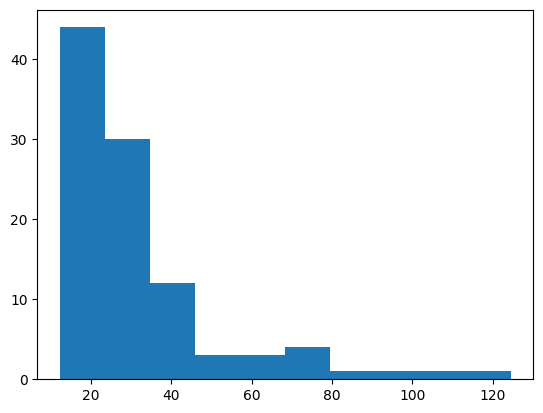

In [3]:
totalevals = [[24.323876893159017, 36.359563220856494, 19.740620773756273, 68.0970588932666, 14.6869765298481, 26.194737430612385, 20.716940014826626, 26.66802907765607, 25.191015879363498, 75.37549399932627, 22.942131953609874, 16.99788729321321, 17.83172195501298, 19.94632826433727, 21.93294060076163, 14.777917564936555, 20.511874662141246, 28.680200434816935, 68.38288215973495, 14.95856459709248, 35.06311694317527, 72.13227913196971, 34.74619811511829, 13.306317730015564, 37.252231891496486, 24.344546772790125, 51.05676569875885, 14.411421380491245, 36.456143509228916, 30.598652476317348, 18.733916630110706, 38.59430554088477, 14.394743214564642, 33.26789451009615, 32.140247310307984, 21.2565316316617, 24.091485253001423, 25.758192402970675, 33.07193127693996, 26.325802211192787, 27.340698666429905, 18.7112454444912, 17.28471024365618, 16.70120238479691, 39.88964013956192, 22.645634339064998, 88.83513415599162, 16.66765947562289, 51.0680224716, 20.872662897590082, 33.477827748835935, 17.443879361026433, 15.364482713298333, 42.86010585650582, 37.45445393034554, 77.56989903511769, 19.95054211445882, 31.527019363865435, 23.525454651796483, 43.85886311023365, 19.22409634508752, 12.765235720435948, 12.336965705190938, 62.29870149110468, 23.100949179079777, 15.607382735899794, 27.309623190793054, 124.45323140726136, 23.316701032252706, 15.622823599369244, 50.20765515162864, 12.988434742191206, 110.35199996322459, 17.863329797385315, 33.28663047170187, 36.67837081663898, 31.034199342120875, 100.87245838178855, 22.362328147999317, 31.585552048174833, 27.568085424188954, 26.961237284853247, 16.270761611147968, 29.362741773801613, 24.48069961329879, 75.94050676022977, 18.250587636911, 13.694774277482676, 14.658178460934524, 16.052671256121734, 25.312053950114688, 15.203580988514858, 33.7388656619569, 31.277332974747196, 16.64348568061874, 39.40760071025541, 31.86317019698973, 32.82650852086061, 43.42304192380067, 17.867809270121583]]
plt.hist(totalevals)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as pt


# visualize learning curves on train/test data
pt.plot(curve[0][0:j+1], 'b-')
pt.plot(curve[1][0:j+1], 'r-')
#pt.plot([0, len(curve[1])], [baseline_error, baseline_error], 'g-')
pt.plot()
pt.legend(["AI","Neural Network"])
pt.show()

In [ ]:
#This method is for game that can be customized by the user

#customizing problem size
#to randomize the starting position we can customize the board. for now I am using a random board setup
#board = chess.Board("r1bqkb1r/pppp1Qpp/2n2n2/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR")
print("We want an input from you to arrange the board. We have randomized the pieces position with different numbers.Can you choose one from the following pieces you want in the board?")
s = input("p or P or Q or R or q or b . Only write the letter \n")
b1 = "8/8/7"+s+"/8/8/r7/1kr5/7K"
b2 = "8/8/8/8/B7/b6"+s+"/1kp5/7K"
b3 = "full board"
b4 = "8/1kr5/7"+s+"/8/8/r7/7K/8"
b5 = "8/7k/p1p2p2p/7"+s+"/8/r7/1K1n4/8"
#b6= "8/8/8/8/8/8/7Q/5k1K"
print("select which problem instance board you want\n b1: ",b1,"\n b2:",b2,"\n b3: ",b3,"\n b4:",b4,"\n b5: ",b5)
b6 = input("Write b1 or b2 or b3 or b4 or b5")
if(b6=="b1"):
    board = chess.Board(b1)
elif(b6=="b2"):
    board = chess.Board(b2) 
elif(b6=="b3"):
    board = chess.Board()
elif(b6=="b4"):
    board = chess.Board(b4)
else:
    board = chess.Board(b6)
score=0

#to let the pc choose random positions
#board = chess.Board.from_chess960_pos(random.randint(0, 959))
#board = chess.Board()
print(board)
#display_board(board)
choice=int(input("Do you want 1. AI-AI game or 2.Human-AI game or 3.Baseline tree-AI tree game or 4. tree vs tree or 5.AI-NN game ?\n write 1 or 2 or 3 or 4 or 5= "))
base1="Tree"
base2="Tree"
white = 1

if(choice==3):
    base1 = "Tree"

elif (choice==5):
    base2="NN"
    #white=0
elif(choice==4):
    base1="Tree"
    base2 = "Tree"
moves = 0
pgn = []
game = chess.pgn.Game()
evaluations = []
sm = 0
cnt = 0
curve  = [ [0]*2 for i in range(2)]
# curve = np.zeros((5,100,1000,2))

j=0
while((not board.is_game_over())):
    all_moves = [board.san(i) for i in list(board.legal_moves)]
    start = time.time()
    if(white==1):
        root = node(board)
        root.state = board
        result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
        print("time taken to iteration",j,(time.time()-start))
    elif(choice==2 and white==0):
        print("input format should be something like a2, b6, g3, first one is row, second one is colum")
        print("row is a to h and colum is 1 to 8. if you are second player your pieces are small letter , otherwise capital")
        to=input("Write where you want to go = ")
        frm = input("write from where you want to move = ")
        result=frm+to
    elif(choice==5 and white==0):
        start = time.time()
        #matrix = make_matrix(board.copy())
        translated = np.array(translate(matrix,chess_dict))
        #print(model.predict(translated.reshape(1,8,8,12)))
        #clear_output()
        #result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
        result = calculate_move(3,board,5)
        #print("time taken for nn in iteration ",j,(time.time()-start))
    else:
        root = node(board)
        root.state = board
        result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
        print("time taken to iteration",j,(time.time()-start))
    try:
        board.push_san(result)

    except:
        print(result)
        print("invalid move. game over")
        break
    #print(result)
    score = staticAnalysis(board,white)
    col="BLACK"
    if(white):
        col="WHITE"
    print("score for ",col,"= ",score)

    curve[white].append(score)
    pgn.append(result)
    white ^= 1
    j+=1

    moves+=1
    #info = engine.analyse(board, chess.engine.Limit(depth=24))
    #evaluat += info['score'].white()
    print(board)

    print("-----------move done-----------")

print(" ".join(pgn))
print()
#{'string': 'NNUE evaluation using nn-ad9b42354671.nnue enabled', 'depth': 24, 'seldepth': 24, 'multipv': 1, 'score': PovScore(Cp(0), WHITE), 'nodes': 103968, 'nps': 4725818, 'hashfull': 7, 'tbhits': 0, 'time': 0.022, 'pv': [Move.from_uci('h1g2'), Move.from_uci('b4b5'), Move.from_uci('g2g3'), Move.from_uci('b5c5'), Move.from_uci('g3f4'), Move.from_uci('c5b4'), Move.from_uci('f4f5'), Move.from_uci('b4c5')]}

#print(info)
#print(evaluations)
#We are showing score for each player after each move, so in final result the score is only based on the winner.
#If player 1 wins, it should show 1-0 , if there is a draw it will show 1/2-1/2 and 0-1 otherwise.
print(board.result())

game.headers["Result"] = board.result()


In [ ]:
import numpy as np
import matplotlib.pyplot as pt

# visualize learning curves on train/test data
pt.plot(curve[0][0:j], 'b-')
pt.plot(curve[1][0:j], 'r-')
#pt.plot([0, len(curve[1])], [baseline_error, baseline_error], 'g-')
pt.plot()
pt.legend(["Human","AI"])
pt.show()

In [ ]:
#This method is for game that can be customized by the user

#customizing problem size
#to randomize the starting position we can customize the board. for now I am using a random board setup
#board = chess.Board("r1bqkb1r/pppp1Qpp/2n2n2/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR")
print("We want an input from you to arrange the board. We have randomized the pieces position with different numbers.Can you choose one from the following pieces you want in the board?")
s = input("p or P or Q or R or q or b . Only write the letter \n")
b1 = "8/8/7"+s+"/8/8/r7/1kr5/7K"
b2 = "8/8/8/8/B7/b6"+s+"/1kp5/7K"
b3 = "full board"
b4 = "8/1kr5/7"+s+"/8/8/r7/7K/8"
b5 = "8/7k/p1p2p2p/7"+s+"/8/r7/1K1n4/8"
#b6= "8/8/8/8/8/8/7Q/5k1K"
print("select which problem instance board you want\n b1: ",b1,"\n b2:",b2,"\n b3: ",b3,"\n b4:",b4,"\n b5: ",b5)
b6 = input("Write b1 or b2 or b3 or b4 or b5")
if(b6=="b1"):
    board = chess.Board(b1)
elif(b6=="b2"):
    board = chess.Board(b2) 
elif(b6=="b3"):
    board = chess.Board()
elif(b6=="b4"):
    board = chess.Board(b4)
else:
    board = chess.Board(b6)
score=0

#to let the pc choose random positions
#board = chess.Board.from_chess960_pos(random.randint(0, 959))
#board = chess.Board()
print(board)
#display_board(board)
choice=int(input("Do you want 1. AI-AI game or 2.Human-AI game or 3.Baseline tree-AI tree game or 4. tree vs tree or 5.AI-NN game ?\n write 1 or 2 or 3 or 4 or 5= "))
base1="Tree"
base2="Tree"
white = 1

if(choice==3):
    base1 = "Tree"

elif (choice==5):
    base2="NN"
    #white=0
elif(choice==4):
    base1="Tree"
    base2 = "Tree"
moves = 0
pgn = []
game = chess.pgn.Game()
evaluations = []
sm = 0
cnt = 0
curve  = [ [0]*2 for i in range(2)]
# curve = np.zeros((5,100,1000,2))

j=0
while((not board.is_game_over())):
    all_moves = [board.san(i) for i in list(board.legal_moves)]
    start = time.time()
    if(white==1):
        root = node(board)
        root.state = board
        result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
        print("time taken to iteration",j,(time.time()-start))
    elif(choice==2 and white==0):
        print("input format should be something like a2, b6, g3, first one is row, second one is colum")
        print("row is a to h and colum is 1 to 8. if you are second player your pieces are small letter , otherwise capital")
        to=input("Write where you want to go = ")
        frm = input("write from where you want to move = ")
        result=frm+to
    elif(choice==5 and white==0):
        start = time.time()
        #matrix = make_matrix(board.copy())
        translated = np.array(translate(matrix,chess_dict))
        #print(model.predict(translated.reshape(1,8,8,12)))
        #clear_output()
        #result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
        result = calculate_move(3,board,5)
        #print("time taken for nn in iteration ",j,(time.time()-start))
    else:
        root = node(board)
        root.state = board
        result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
        print("time taken to iteration",j,(time.time()-start))
    try:
        board.push_san(result)

    except:
        print(result)
        print("invalid move. game over")
        break
    #print(result)
    score = staticAnalysis(board,white)
    col="BLACK"
    if(white):
        col="WHITE"
    print("score for ",col,"= ",score)

    curve[white].append(score)
    pgn.append(result)
    white ^= 1
    j+=1

    moves+=1
    #info = engine.analyse(board, chess.engine.Limit(depth=24))
    #evaluat += info['score'].white()
    print(board)

    print("-----------move done-----------")

print(" ".join(pgn))
print()
#{'string': 'NNUE evaluation using nn-ad9b42354671.nnue enabled', 'depth': 24, 'seldepth': 24, 'multipv': 1, 'score': PovScore(Cp(0), WHITE), 'nodes': 103968, 'nps': 4725818, 'hashfull': 7, 'tbhits': 0, 'time': 0.022, 'pv': [Move.from_uci('h1g2'), Move.from_uci('b4b5'), Move.from_uci('g2g3'), Move.from_uci('b5c5'), Move.from_uci('g3f4'), Move.from_uci('c5b4'), Move.from_uci('f4f5'), Move.from_uci('b4c5')]}

#print(info)
#print(evaluations)
#We are showing score for each player after each move, so in final result the score is only based on the winner.
#If player 1 wins, it should show 1-0 , if there is a draw it will show 1/2-1/2 and 0-1 otherwise.
print(board.result())

game.headers["Result"] = board.result()
